# Lab Activity 3: EM for Gaussian Mixtures

The goal of this activity is to implement the Expectation-Maximization algorithm for training models that are mixtures of Gaussians.

## 1. Some background

First grab numpy and scipy.stats, we'll need those.

In [3]:
import numpy as np
from scipy.stats import norm

Here is a class that I've written for object that stand for mixtures of Gaussians. 
The idea is that any instance of this class is a probability density function
composed of Gaussian pdfs.
It is itself callable, that is, it acts like a pdf.
If variable <code>p</code> refers to a <code>MixedGaussian</code>, then you can call <code>p(x_i)</code>
for some data point <code>x_i</code>.
But also it is indexable, that is, you can retrieve the jth weighted Gaussian.
The expression <code>p[i](x_i)</code> finds the probability of <code>x_i</code> in the jth component model
(weight included).

Think through this code carefully.
I don't know if this is the most Pythonic approach, but to my object-oriented mind it seemed like
the right thing to do.

In [4]:
class MixedGaussian :
    # pi, mu, and sigma are lists. pi[j], for example, is the mixing coefficient for the jth component
    def __init__(self, pi, mu, sigma):
        self.k = len(pi)
        assert self.k == len(mu)
        assert self.k == len(sigma)
        self.pi = pi
        self.mu = mu
        self.sigma = sigma
    
    # Retrieve the jth weighted component (returned as a pdf)
    def __getitem__(self, j):
        return lambda x : self.pi[j] * norm.pdf(x, self.mu[j], self.sigma[j]) 
    
    # Act like a pdf
    def __call__(self, x):
        return  sum(self[j](x) for j in range(self.k))
    
    def __str__(self):
        return " + ".join([str(self.pi[j]) + "N(" + str(self.mu[j]) + "," + str(self.sigma[j])+")" for j in range(self.k)])


Here's a function that will plot a pdf on a given range from a to b.

In [5]:
import matplotlib.pyplot as plt
def display_pdf(p, a, b) :
    rng = np.linspace(a, b)
    plt.plot(rng, p(rng))
    plt.show()


## 2. Gaussian Mixtures when we know everything.

Let's try out this class. Let's do three Gaussians with specified weights, means, and standard deviations.

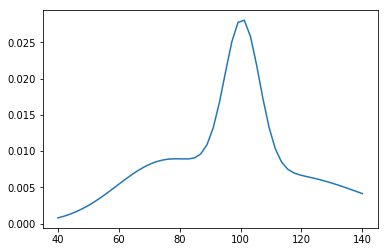

In [6]:
mg = MixedGaussian([.25, .3, .45], [73.0, 100.5, 113.7], [15.3, 5.7, 26.7])
display_pdf(mg, 40, 140)

And let's use the data from last time to make a Gaussian mixture, again with all information.

In [7]:
import pandas as pd
heightweight = pd.read_csv("data/weight-height.csv")

In [8]:
male_heights = heightweight[heightweight.Gender=="Male"]["Height"]
male_mu = np.mean(male_heights)
male_sigma = np.sqrt(np.var(male_heights))
female_heights = heightweight[heightweight.Gender=="Female"]["Height"]
female_mu = np.mean(female_heights)
female_sigma = np.sqrt(np.var(female_heights))
N = heightweight.shape[0]
actual_height = MixedGaussian([len(male_heights)/N,len(female_heights)/N],
                          [male_mu, female_mu], [male_sigma, female_sigma])
print(actual_height)

0.5N(69.02634590621741,2.863075878119538) + 0.5N(63.70877360342507,2.696014373880709)


Display it:

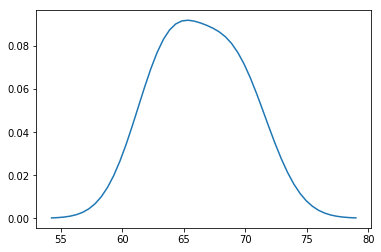

In [9]:
display_pdf(actual_height, min(heightweight["Height"]), max(heightweight["Height"]))

## 3. Training when information is missing.

Now the main point. 
Let's implement EM to train a Gaussian mixture with only the observations, no information
about which component the observations came from.

First a helper function to compute the log likelihood, which you'll use to test for convergence.

In [10]:
def log_likelihood(p, X):
    return sum([np.log(p(x_i)) for x_i in X])


Ok, implement EM! 
You can do this from scratch if you want, but here is a function stub if you find it easier.

In [20]:
def train(X, k, pi_initial=None, mu_initial=None, sigma_initial = None, epsilon = 0.0001):

    minv = min(X)
    maxv = max(X)
    
    # Initial parameters
    if pi_initial :
        assert len(pi_initial) == k
        assert abs(1-sum(pi_initial)) < epsilon
        pi = pi_initial
    else:
        pi = [1/k for i in range(k)]
    if mu_initial :
        assert len(mu_initial) == k
        mu = mu_initial
    else : 
        incr = (maxv - minv) / (k+1)
        mu = [minv + (j+1)*incr for j in range(k)]
    if sigma_initial:
        assert len(sigma_initial) == k
        sigma = sigma_initial
    else :
        sigma = [(maxv-minv) / k**2 for j in range(k)]

    # Initial gaussian mixture and log likelihood
    mg = MixedGaussian(pi, mu, sigma)

    # I recommend you print out the initial model
    # and that you count the iterations. 
    # Moreover, I recommend that at the end of each step you print out
    # the current log likelihood (which will be a negative number)
    # and the difference between the current and the previous
    # (which will be a positive number, small at the end).
    # This is an important sanity check: If the log likelihoods are
    # not getting bigger then something is wrong. The differences
    # will tell you how close you are getting to convergence.
    print(mg)
    loglike = log_likelihood(mg, X)
    prev_loglike = 0
    print("Initial loglike: " + str(loglike))
    iterations = 0
    
    while abs(loglike - prev_loglike) > epsilon:
        
        #evaluate
        for j in range(k):
            for x in X:
                gamma = mg[j](x)/mg(x)
                N[j][x] = gamma
                denom[x] += gamma
                Nj[j] += gamma
        
        #maximize
        for j in range(k):
            
            #calculate Nj
            Nj = 0
            numMu = 0
            numSig = 0
            for x in X:
                gamma = mg[j](x)/mg(x)
                Nj += gamma
                numMu += gamma * x
                numSig += gamma * ((x - mu[j]) ** 2)

            #new mu
            mu[j] = numMu/Nj

            #new sigma
            sigma[j] = (numSig/Nj) ** .5

            #new pi
            pi[j] = Nj/len(X)
        
        prev_loglike = loglike
        loglike = log_likelihood(mg, X)
        
        mg = MixedGaussian(pi, mu, sigma)
        
        #print(loglike)
        print(abs(loglike - prev_loglike))
            
        iterations += 1
    print(str(iterations) + " iterations")
    return mg


## 4. Try it out

First try it out on a small set of data, just 9 data points (drawn from the height data).

In [21]:
few_heights = [73.847017, 68.781904, 74.110105, 71.730978, 69.881796, 67.253016, 63.867992, 69.034243, 61.944246]

fh_trained = train(few_heights, 2)
print(fh_trained)


0.5N(65.99953233333333,3.041464750000001) + 0.5N(70.05481866666668,3.041464750000001)
Initial loglike: -25.220882690378193


TypeError: 'int' object is not subscriptable

Let's see it.

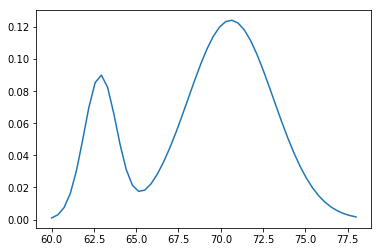

In [18]:
display_pdf(fh_trained, 60,78)

Now the real test: Can it find the distributions of height if we give it only the heights, not the genders?

In [19]:
trained_height = train(heightweight["Height"], 2)

0.5N(62.508336332194595,6.183902255323122) + 0.5N(70.75353933929209,6.183902255323122)
Initial loglike: -30765.14138946643
1881.095909329233
893.4383187233543
246.10209888670215
63.51100899526864
16.564294266896468
4.458862719191529
1.300750440612319
0.4712301755171211
0.2588269552725251
0.21375108237407403
0.21504240537979058
0.22937556651959312
0.24752673094917554
0.267124142315879
0.287781071048812
0.30967341711584595
0.3331198998930631
0.35846558661796735
0.3860584902467963
0.4162536538169661
0.4494241702122963
0.4859730460011633
0.5263445060772938
0.5710347604363051
0.6206025752835558
0.6756799869181123
0.7369833861412189
0.8053250276680046
0.8816248225339223
0.9669220024225069
1.0623859032821201
1.1693245756796387
1.2891892233856197
1.423571434301266
1.57418870670881
1.7428518296728726
1.9314049946806335
2.141626165386697
2.375071087568358
2.6328398130935966
2.915240468526463
3.22132308023356
3.5482598048802174
3.8905624895560322
4.23916203853878
4.580436593492777
4.8953752562265

0.0015644957711629104
0.0015586962108500302
0.001552901892864611
0.001547112231492065
0.0015413283617817797
0.001535549403342884
0.0015297772151825484
0.0015240102584357373
0.001518250115623232
0.001512495793576818
0.0015067487438500393
0.0015010076749604195
0.001495274616900133
0.001489548412791919
0.0014838299903203733
0.001478118745581014
0.0014724151296832133
0.0014667208379250951
0.0014610335892939474
0.0014553549262927845
0.00144968483800767
0.0014440239501709584
0.0014383715752046555
0.0014327280623547267
0.0014270943102019373
0.0014214700713637285
0.0014158547492115758
0.0014102498316788115
0.0014046539836272132
0.0013990693951200228
0.0013934937524027191
0.0013879291072953492
0.0013823748122376855
0.001376830565277487
0.0013712980180571321
0.0013657756135216914
0.0013602646977233235
0.0013547646303777583
0.001349275749817025
0.0013437986199278384
0.00133833235304337
0.0013328783606993966
0.001327436046267394
0.0013220050423115026
0.0013165865311748348
0.0013111798107274808
0.0

KeyboardInterrupt: 

Look at resulting model. How do its parameters compare to the parameters of the real one?

In [69]:
print(trained_height)

0.5819153742806906N(65.54936412711065,3.6847172372011494) + 0.4183739619061869N(67.51073150728523,3.7768936907873094)


And let's look at the graph, of course.

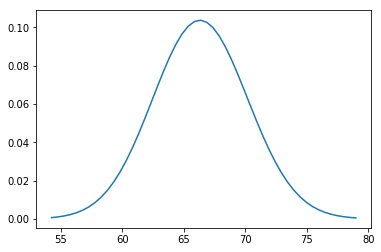

In [70]:
display_pdf(trained_height, min(heightweight["Height"]), max(heightweight["Height"]))

## 5. What next?

This might be a moot question since it might take you the rest of class time to debug (if not just write) your EM function. 
But if it seems to work so far, then try it on different data: try it on weight, 
or try it on height but without an even split between male and female in the training data,
or go off and find your own data to try it on.

Or if you want a real challenge, improve your implementation to work on multidimensional data (height and weight, for example).